#### Session 1: Setup

In [1]:
import json
import logging
import sys
from pathlib import Path
import ipytest
import os
import sagemaker
from sagemaker.workflow.pipeline_context import LocalPipelineSession, PipelineSession
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from code import Configuration


CODE_FOLDER = Path("code")
sys.path.extend([f"./{CODE_FOLDER}"])

DATA_FILEPATH = "penguins.csv"

ipytest.autoconfig(raise_on_error=True)

logging.getLogger("sagemaker.config").setLevel(logging.ERROR)


sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/carlodavid/Library/Application Support/sagemaker/config.yaml


In [1]:
LOCAL_MODE = True
config = Configuration(LOCAL_MODE)

NameError: name 'Configuration' is not defined

In [6]:
S3_LOCATION = f"s3://{bucket}/penguins"

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

#### Session 2: EDA

In [7]:


penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [8]:
# summary statistics of dataset
penguins.describe(include="all")

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


In [9]:
# distribution of categorical columns
species_distribution = penguins["species"].value_counts()
island_distribution = penguins["island"].value_counts()
sex_distribution = penguins["sex"].value_counts()

print(species_distribution, "\n")
print(island_distribution,  "\n")
print(sex_distribution)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64 

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64 

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64


In [10]:
# replace ambiguous value in sex column
penguins["sex"] = penguins["sex"].replace(".", np.nan)

sex_distribution = penguins["sex"].value_counts()
sex_distribution

sex
MALE      168
FEMALE    165
Name: count, dtype: int64

In [11]:
# check missing values
penguins.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [12]:
# replace missing values with most frequent value

imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:, :] = imputer.fit_transform(penguins)

penguins.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

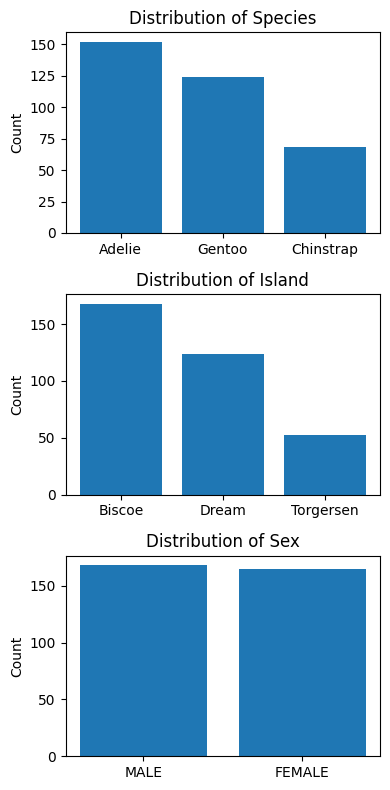

In [13]:

fig, axs = plt.subplots(3, 1, figsize=(4, 8))

axs[0].bar(species_distribution.index, species_distribution.values)
axs[0].set_ylabel("Count")
axs[0].set_title("Distribution of Species")

axs[1].bar(island_distribution.index, island_distribution.values)
axs[1].set_ylabel("Count")
axs[1].set_title("Distribution of Island")

axs[2].bar(sex_distribution.index, sex_distribution.values)
axs[2].set_ylabel("Count")
axs[2].set_title("Distribution of Sex")

plt.tight_layout()
plt.show()


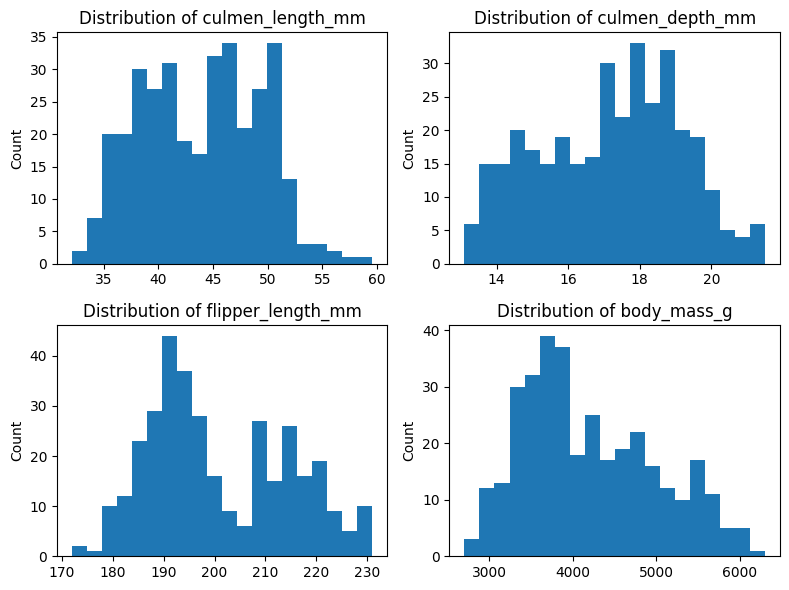

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].hist(penguins["culmen_length_mm"], bins=20)
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_title("Distribution of culmen_length_mm")

axs[0, 1].hist(penguins["culmen_depth_mm"], bins=20)
axs[0, 1].set_ylabel("Count")
axs[0, 1].set_title("Distribution of culmen_depth_mm")

axs[1, 0].hist(penguins["flipper_length_mm"], bins=20)
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_title("Distribution of flipper_length_mm")

axs[1, 1].hist(penguins["body_mass_g"], bins=20)
axs[1, 1].set_ylabel("Count")
axs[1, 1].set_title("Distribution of body_mass_g")

plt.tight_layout()
plt.show()

In [15]:
# covariance
penguins.cov(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,29.679415,-2.516984,50.260588,2596.971151
culmen_depth_mm,-2.516984,3.877201,-16.108849,-742.660180
flipper_length_mm,50.260588,-16.108849,197.269501,9792.552037
body_mass_g,2596.971151,-742.660180,9792.552037,640316.716388


In [16]:
# correlation matrix
penguins.corr(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.234635,0.656856,0.595720
culmen_depth_mm,-0.234635,1.000000,-0.582472,-0.471339
flipper_length_mm,0.656856,-0.582472,1.000000,0.871302
body_mass_g,0.595720,-0.471339,0.871302,1.000000
